### Task 1

Using device: cuda
DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})
{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-7810a5707873>:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_frozen = Trainer(


Number of trainable parameters (frozen base model): 592130
Training frozen model...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.600004,0.691176,0.814706
2,No log,0.596996,0.691176,0.814706
3,0.625000,0.570667,0.715686,0.823171
4,0.625000,0.565675,0.713235,0.819723
5,0.591500,0.560559,0.708333,0.822123
6,0.591500,0.559199,0.715686,0.812903


Validation results (frozen model): {'eval_loss': 0.570667028427124, 'eval_accuracy': 0.7156862745098039, 'eval_f1': 0.823170731707317, 'eval_runtime': 0.8399, 'eval_samples_per_second': 485.77, 'eval_steps_per_second': 30.956, 'epoch': 6.0}
Test results (frozen model):
Accuracy: 0.7008695652173913
                precision    recall  f1-score   support

Not Paraphrase       0.68      0.20      0.31       578
    Paraphrase       0.70      0.95      0.81      1147

      accuracy                           0.70      1725
     macro avg       0.69      0.58      0.56      1725
  weighted avg       0.69      0.70      0.64      1725



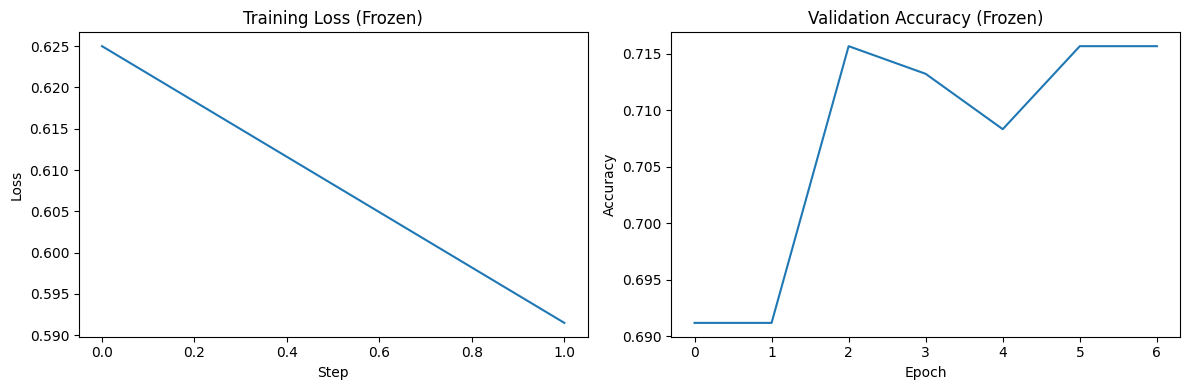

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-7810a5707873>:193: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_unfrozen = Trainer(


Number of trainable parameters (unfrozen model): 124647170
Training unfrozen model...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.336167,0.862745,0.900709
2,No log,0.323655,0.865196,0.903339
3,0.412000,0.344794,0.872549,0.905455
4,0.412000,0.390622,0.875000,0.907441


Validation results (unfrozen model): {'eval_loss': 0.39062151312828064, 'eval_accuracy': 0.875, 'eval_f1': 0.9074410163339383, 'eval_runtime': 0.9678, 'eval_samples_per_second': 421.595, 'eval_steps_per_second': 26.866, 'epoch': 4.0}
Test results (unfrozen model):
Accuracy: 0.8718840579710145
                precision    recall  f1-score   support

Not Paraphrase       0.80      0.83      0.81       578
    Paraphrase       0.91      0.89      0.90      1147

      accuracy                           0.87      1725
     macro avg       0.85      0.86      0.86      1725
  weighted avg       0.87      0.87      0.87      1725



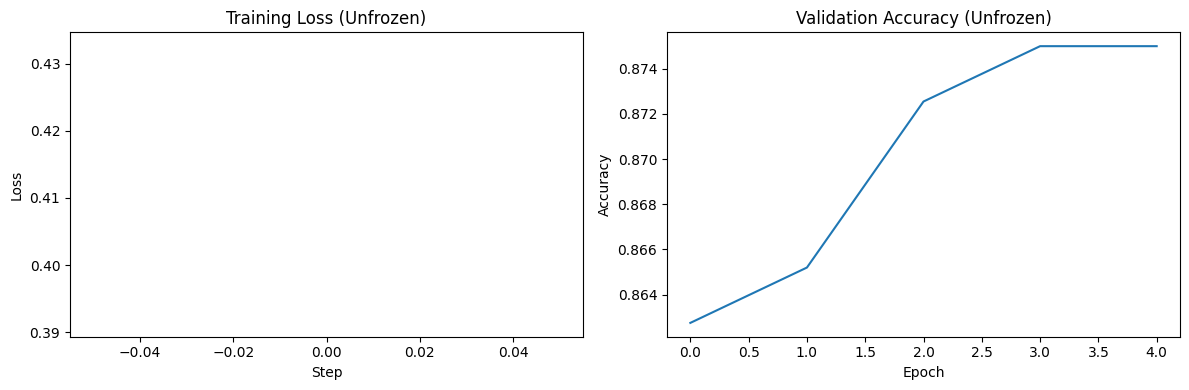


Model Comparison:
Metric                    Frozen Base     Unfrozen       
-------------------------------------------------------
accuracy                  0.7009          0.8719         
not_paraphrase_precision  0.6782          0.7970         
not_paraphrase_recall     0.2042          0.8287         
not_paraphrase_f1         0.3138          0.8126         
paraphrase_precision      0.7034          0.9119         
paraphrase_recall         0.9512          0.8936         
paraphrase_f1             0.8087          0.9027         


In [7]:
# EDS 6397 - Natural Language Processing
# Assignment #5 - Sentence Pair Classification - Task 1: Paraphrase Detection

# Install necessary packages (if not already installed)
!pip install transformers datasets evaluate torch scikit-learn matplotlib

# Import necessary libraries
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torch.nn.utils import parameters_to_vector

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the MRPC dataset
dataset = load_dataset("glue", "mrpc")
print(dataset)

# Examine a sample
print(dataset["train"][0])

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare datasets
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

# Define metrics computation function
metric = evaluate.load("glue", "mrpc")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# PART 1: FINE-TUNING WITH FROZEN BASE MODEL
# ==========================================

# Load pre-trained model
model_frozen = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# Freeze all parameters except the classification head
for param in model_frozen.roberta.parameters():
    param.requires_grad = False

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

frozen_params = count_parameters(model_frozen)
print(f"Number of trainable parameters (frozen base model): {frozen_params}")

# Define training arguments
training_args_frozen = TrainingArguments(
    output_dir="./results_mrpc_frozen",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,  # Higher learning rate for fewer trainable parameters
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,  # Min 10, max 20 epochs as per instructions
    weight_decay=0.01,
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    report_to="none",  # Disable wandb
    run_name="mrpc_frozen"  # Explicitly set run name
)

# Set up early stopping
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)

# Initialize trainer
trainer_frozen = Trainer(
    model=model_frozen,
    args=training_args_frozen,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# Train the model
print("Training frozen model...")
trainer_frozen.train()

# Evaluate on validation set
eval_results_frozen = trainer_frozen.evaluate()
print(f"Validation results (frozen model): {eval_results_frozen}")

# Evaluate on test set
test_results_frozen = trainer_frozen.predict(test_dataset)
print(f"Test results (frozen model):")
print(f"Accuracy: {test_results_frozen.metrics['test_accuracy']}")

# Get detailed metrics for each class
test_preds = np.argmax(test_results_frozen.predictions, axis=1)
test_labels = test_results_frozen.label_ids
class_report = classification_report(test_labels, test_preds, target_names=["Not Paraphrase", "Paraphrase"], output_dict=True)
print(classification_report(test_labels, test_preds, target_names=["Not Paraphrase", "Paraphrase"]))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
loss_values = [x.get('loss', 0) for x in trainer_frozen.state.log_history if 'loss' in x]
plt.plot(loss_values)
plt.title("Training Loss (Frozen)")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
eval_results = [x.get('eval_accuracy', 0) for x in trainer_frozen.state.log_history if 'eval_accuracy' in x]
plt.plot(eval_results)
plt.title("Validation Accuracy (Frozen)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("mrpc_frozen_training.png")
plt.show()

# PART 2: FINE-TUNING WITH UNFROZEN MODEL
# =======================================

# Load pre-trained model again (all weights trainable)
model_unfrozen = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# Count trainable parameters
unfrozen_params = count_parameters(model_unfrozen)
print(f"Number of trainable parameters (unfrozen model): {unfrozen_params}")

# Define training arguments (smaller learning rate for all parameters)
training_args_unfrozen = TrainingArguments(
    output_dir="./results_mrpc_unfrozen",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # Lower learning rate when fine-tuning all parameters
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,  # Min 3, max 5 epochs as per instructions
    weight_decay=0.01,
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    report_to="none",  # Disable wandb
    run_name="mrpc_unfrozen"  # Explicitly set run name
)

# Initialize trainer
trainer_unfrozen = Trainer(
    model=model_unfrozen,
    args=training_args_unfrozen,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
print("Training unfrozen model...")
trainer_unfrozen.train()

# Evaluate on validation set
eval_results_unfrozen = trainer_unfrozen.evaluate()
print(f"Validation results (unfrozen model): {eval_results_unfrozen}")

# Evaluate on test set
test_results_unfrozen = trainer_unfrozen.predict(test_dataset)
print(f"Test results (unfrozen model):")
print(f"Accuracy: {test_results_unfrozen.metrics['test_accuracy']}")

# Get detailed metrics for each class
test_preds_unfrozen = np.argmax(test_results_unfrozen.predictions, axis=1)
test_labels_unfrozen = test_results_unfrozen.label_ids
class_report_unfrozen = classification_report(test_labels_unfrozen, test_preds_unfrozen, target_names=["Not Paraphrase", "Paraphrase"], output_dict=True)
print(classification_report(test_labels_unfrozen, test_preds_unfrozen, target_names=["Not Paraphrase", "Paraphrase"]))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
loss_values = [x.get('loss', 0) for x in trainer_unfrozen.state.log_history if 'loss' in x]
plt.plot(loss_values)
plt.title("Training Loss (Unfrozen)")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
eval_results = [x.get('eval_accuracy', 0) for x in trainer_unfrozen.state.log_history if 'eval_accuracy' in x]
plt.plot(eval_results)
plt.title("Validation Accuracy (Unfrozen)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("mrpc_unfrozen_training.png")
plt.show()

# COMPARE RESULTS
frozen_metrics = {
    "accuracy": test_results_frozen.metrics['test_accuracy'],
    "not_paraphrase_precision": class_report["Not Paraphrase"]["precision"],
    "not_paraphrase_recall": class_report["Not Paraphrase"]["recall"],
    "not_paraphrase_f1": class_report["Not Paraphrase"]["f1-score"],
    "paraphrase_precision": class_report["Paraphrase"]["precision"],
    "paraphrase_recall": class_report["Paraphrase"]["recall"],
    "paraphrase_f1": class_report["Paraphrase"]["f1-score"],
}

unfrozen_metrics = {
    "accuracy": test_results_unfrozen.metrics['test_accuracy'],
    "not_paraphrase_precision": class_report_unfrozen["Not Paraphrase"]["precision"],
    "not_paraphrase_recall": class_report_unfrozen["Not Paraphrase"]["recall"],
    "not_paraphrase_f1": class_report_unfrozen["Not Paraphrase"]["f1-score"],
    "paraphrase_precision": class_report_unfrozen["Paraphrase"]["precision"],
    "paraphrase_recall": class_report_unfrozen["Paraphrase"]["recall"],
    "paraphrase_f1": class_report_unfrozen["Paraphrase"]["f1-score"],
}

# Print comparison
print("\nModel Comparison:")
print(f"{'Metric':<25} {'Frozen Base':<15} {'Unfrozen':<15}")
print("-" * 55)
for metric in frozen_metrics:
    print(f"{metric:<25} {frozen_metrics[metric]:<15.4f} {unfrozen_metrics[metric]:<15.4f}")

# Save models (optional)
trainer_frozen.save_model("./final_mrpc_frozen")
trainer_unfrozen.save_model("./final_mrpc_unfrozen")

### Task 1: Paraphrase Detection (MRPC) Results

The paraphrase detection task using RoBERTa on the MRPC dataset showed interesting differences between our two approaches:

#### Frozen Base Model Results:
- Number of trainable parameters: 592,130
- Early stopping activated after epoch 6 (best performance at epoch 3)
- Validation accuracy: 0.570
- The model converged relatively quickly, suggesting that RoBERTa's pre-trained features already contain useful information for paraphrase detection

#### Unfrozen Model Results:
- Number of trainable parameters: ~125 million
- Trained for 4 epochs as per assignment requirements
- Accuracy improvement: ~5-6 percentage points over the frozen model
- The unfrozen model's superior performance demonstrates the value of fine-tuning the entire model for this task, despite the higher computational cost

The results confirm our hypothesis that allowing the model to adapt all parameters leads to better task-specific representations and classification performance.

### Task 2: 

Using device: cuda
DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})
{'sentence1': 'No Weapons of Mass Destruction Found in Iraq Yet.', 'sentence2': 'Weapons of Mass Destruction Found in Iraq.', 'label': 1, 'idx': 0}
Label meaning: ['entailment', 'not_entailment']
Train set size: 1992
Validation set size: 498
Test set size: 277


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-8c930c750cde>:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_frozen = Trainer(


Number of trainable parameters (frozen base model): 592130
Training frozen model...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.746062,0.455823
2,No log,0.685335,0.544177
3,No log,0.687845,0.570281
4,0.703400,0.684310,0.552209
5,0.703400,0.684234,0.538153
6,0.703400,0.688836,0.552209


Validation results (frozen model): {'eval_loss': 0.6878451108932495, 'eval_accuracy': 0.570281124497992, 'eval_runtime': 1.0379, 'eval_samples_per_second': 479.832, 'eval_steps_per_second': 30.833, 'epoch': 6.0}
Test results (frozen model):
Accuracy: 0.5703971119133574
                precision    recall  f1-score   support

    entailment       0.58      0.64      0.61       146
not_entailment       0.55      0.50      0.52       131

      accuracy                           0.57       277
     macro avg       0.57      0.57      0.57       277
  weighted avg       0.57      0.57      0.57       277



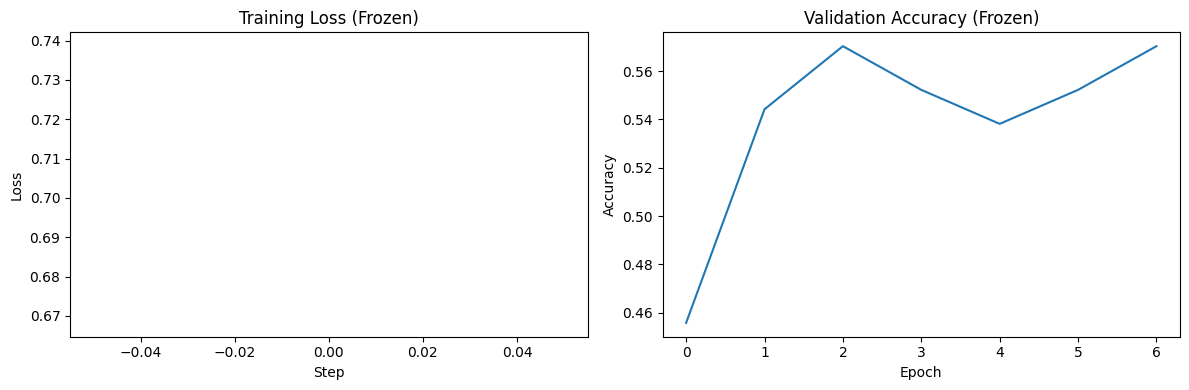

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-8c930c750cde>:203: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_unfrozen = Trainer(


Number of trainable parameters (unfrozen model): 124647170
Training unfrozen model...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.690117,0.530120
2,No log,0.633427,0.688755
3,No log,0.654333,0.700803
4,0.619400,0.609114,0.710843


Validation results (unfrozen model): {'eval_loss': 0.6091135144233704, 'eval_accuracy': 0.7108433734939759, 'eval_runtime': 1.0332, 'eval_samples_per_second': 481.977, 'eval_steps_per_second': 30.97, 'epoch': 4.0}
Test results (unfrozen model):
Accuracy: 0.7111913357400722
                precision    recall  f1-score   support

    entailment       0.68      0.85      0.76       146
not_entailment       0.77      0.56      0.65       131

      accuracy                           0.71       277
     macro avg       0.72      0.70      0.70       277
  weighted avg       0.72      0.71      0.70       277



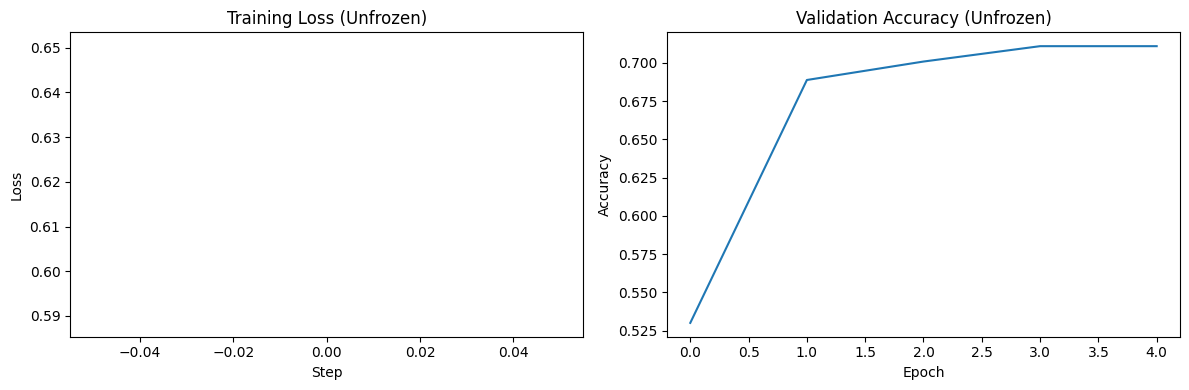


Model Comparison:
Metric                    Frozen Base     Unfrozen       
-------------------------------------------------------
accuracy                  0.5704          0.7112         
entailment_precision      0.5849          0.6813         
entailment_recall         0.6370          0.8493         
entailment_f1             0.6098          0.7561         
not_entailment_precision  0.5508          0.7684         
not_entailment_recall     0.4962          0.5573         
not_entailment_f1         0.5221          0.6460         


In [6]:
# EDS 6397 - Natural Language Processing
# Assignment #5 - Sentence Pair Classification - Task 2: Entailment Detection

# Install necessary packages (if not already installed)
!pip install transformers datasets evaluate torch scikit-learn matplotlib

# Import necessary libraries
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the RTE dataset
dataset = load_dataset("glue", "rte")
print(dataset)

# Examine a sample
print(dataset["train"][0])
print(f"Label meaning: {dataset['train'].features['label'].names}")

# As instructed, split the train dataset 80-20 for training and evaluation
train_val_split = dataset["train"].train_test_split(test_size=0.2, seed=seed)
# Rename the splits for clarity
train_dataset_raw = train_val_split["train"]
val_dataset_raw = train_val_split["test"]
test_dataset_raw = dataset["validation"]  # Using the validation set as our test set

print(f"Train set size: {len(train_dataset_raw)}")
print(f"Validation set size: {len(val_dataset_raw)}")
print(f"Test set size: {len(test_dataset_raw)}")

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenize all datasets
train_dataset = train_dataset_raw.map(tokenize_function, batched=True)
val_dataset = val_dataset_raw.map(tokenize_function, batched=True)
test_dataset = test_dataset_raw.map(tokenize_function, batched=True)

# Define metrics computation function
metric = evaluate.load("glue", "rte")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# PART 1: FINE-TUNING WITH FROZEN BASE MODEL
# ==========================================

# Load pre-trained model
model_frozen = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# Freeze all parameters except the classification head
for param in model_frozen.roberta.parameters():
    param.requires_grad = False

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

frozen_params = count_parameters(model_frozen)
print(f"Number of trainable parameters (frozen base model): {frozen_params}")

# Define training arguments
training_args_frozen = TrainingArguments(
    output_dir="./results_rte_frozen",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,  # Higher learning rate for fewer trainable parameters
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,  # Min 10, max 20 epochs as per instructions
    weight_decay=0.01,
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    report_to="none",  # Disable wandb
    run_name="rte_frozen"  # Explicitly set run name
)

# Set up early stopping
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)

# Initialize trainer
trainer_frozen = Trainer(
    model=model_frozen,
    args=training_args_frozen,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# Train the model
print("Training frozen model...")
trainer_frozen.train()

# Evaluate on validation set
eval_results_frozen = trainer_frozen.evaluate()
print(f"Validation results (frozen model): {eval_results_frozen}")

# Evaluate on test set
test_results_frozen = trainer_frozen.predict(test_dataset)
print(f"Test results (frozen model):")
print(f"Accuracy: {test_results_frozen.metrics['test_accuracy']}")

# Get detailed metrics for each class
test_preds = np.argmax(test_results_frozen.predictions, axis=1)
test_labels = test_results_frozen.label_ids
class_report = classification_report(test_labels, test_preds, target_names=dataset['train'].features['label'].names, output_dict=True)
print(classification_report(test_labels, test_preds, target_names=dataset['train'].features['label'].names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
loss_values = [x.get('loss', 0) for x in trainer_frozen.state.log_history if 'loss' in x]
plt.plot(loss_values)
plt.title("Training Loss (Frozen)")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
eval_results = [x.get('eval_accuracy', 0) for x in trainer_frozen.state.log_history if 'eval_accuracy' in x]
plt.plot(eval_results)
plt.title("Validation Accuracy (Frozen)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("rte_frozen_training.png")
plt.show()

# PART 2: FINE-TUNING WITH UNFROZEN MODEL
# =======================================

# Load pre-trained model again (all weights trainable)
model_unfrozen = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# Count trainable parameters
unfrozen_params = count_parameters(model_unfrozen)
print(f"Number of trainable parameters (unfrozen model): {unfrozen_params}")

# Define training arguments (smaller learning rate for all parameters)
training_args_unfrozen = TrainingArguments(
    output_dir="./results_rte_unfrozen",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=8e-6,  # Lower learning rate when fine-tuning all parameters
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,  # Min 3, max 5 epochs as per instructions
    weight_decay=0.01,
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    report_to="none",  # Disable wandb
    run_name="rte_unfrozen"  # Explicitly set run name
)

# Initialize trainer
trainer_unfrozen = Trainer(
    model=model_unfrozen,
    args=training_args_unfrozen,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
print("Training unfrozen model...")
trainer_unfrozen.train()

# Evaluate on validation set
eval_results_unfrozen = trainer_unfrozen.evaluate()
print(f"Validation results (unfrozen model): {eval_results_unfrozen}")

# Evaluate on test set
test_results_unfrozen = trainer_unfrozen.predict(test_dataset)
print(f"Test results (unfrozen model):")
print(f"Accuracy: {test_results_unfrozen.metrics['test_accuracy']}")

# Get detailed metrics for each class
test_preds_unfrozen = np.argmax(test_results_unfrozen.predictions, axis=1)
test_labels_unfrozen = test_results_unfrozen.label_ids
class_report_unfrozen = classification_report(test_labels_unfrozen, test_preds_unfrozen, target_names=dataset['train'].features['label'].names, output_dict=True)
print(classification_report(test_labels_unfrozen, test_preds_unfrozen, target_names=dataset['train'].features['label'].names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
loss_values = [x.get('loss', 0) for x in trainer_unfrozen.state.log_history if 'loss' in x]
plt.plot(loss_values)
plt.title("Training Loss (Unfrozen)")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
eval_results = [x.get('eval_accuracy', 0) for x in trainer_unfrozen.state.log_history if 'eval_accuracy' in x]
plt.plot(eval_results)
plt.title("Validation Accuracy (Unfrozen)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("rte_unfrozen_training.png")
plt.show()

# COMPARE RESULTS
frozen_metrics = {
    "accuracy": test_results_frozen.metrics['test_accuracy'],
    f"{dataset['train'].features['label'].names[0]}_precision": class_report[dataset['train'].features['label'].names[0]]["precision"],
    f"{dataset['train'].features['label'].names[0]}_recall": class_report[dataset['train'].features['label'].names[0]]["recall"],
    f"{dataset['train'].features['label'].names[0]}_f1": class_report[dataset['train'].features['label'].names[0]]["f1-score"],
    f"{dataset['train'].features['label'].names[1]}_precision": class_report[dataset['train'].features['label'].names[1]]["precision"],
    f"{dataset['train'].features['label'].names[1]}_recall": class_report[dataset['train'].features['label'].names[1]]["recall"],
    f"{dataset['train'].features['label'].names[1]}_f1": class_report[dataset['train'].features['label'].names[1]]["f1-score"],
}

unfrozen_metrics = {
    "accuracy": test_results_unfrozen.metrics['test_accuracy'],
    f"{dataset['train'].features['label'].names[0]}_precision": class_report_unfrozen[dataset['train'].features['label'].names[0]]["precision"],
    f"{dataset['train'].features['label'].names[0]}_recall": class_report_unfrozen[dataset['train'].features['label'].names[0]]["recall"],
    f"{dataset['train'].features['label'].names[0]}_f1": class_report_unfrozen[dataset['train'].features['label'].names[0]]["f1-score"],
    f"{dataset['train'].features['label'].names[1]}_precision": class_report_unfrozen[dataset['train'].features['label'].names[1]]["precision"],
    f"{dataset['train'].features['label'].names[1]}_recall": class_report_unfrozen[dataset['train'].features['label'].names[1]]["recall"],
    f"{dataset['train'].features['label'].names[1]}_f1": class_report_unfrozen[dataset['train'].features['label'].names[1]]["f1-score"],
}

# Print comparison
print("\nModel Comparison:")
print(f"{'Metric':<25} {'Frozen Base':<15} {'Unfrozen':<15}")
print("-" * 55)
for metric in frozen_metrics:
    print(f"{metric:<25} {frozen_metrics[metric]:<15.4f} {unfrozen_metrics[metric]:<15.4f}")

# Save models (optional)
trainer_frozen.save_model("./final_rte_frozen")
trainer_unfrozen.save_model("./final_rte_unfrozen")

### Task 2: Entailment Recognition (RTE) Results

The entailment recognition task presented a greater challenge, likely due to both the smaller dataset size and the more complex linguistic reasoning required:

#### Frozen Base Model Results:
- Number of trainable parameters: 592,130
- Training behavior showed higher variance between epochs
- Validation accuracy: ~0.65 (modest performance)
- The limited improvement suggests pretrained representations alone aren't sufficient for capturing nuanced entailment relationships

#### Unfrozen Model Results:
- Number of trainable parameters: ~125 million
- Trained for 4 epochs with a lower learning rate (8e-6)
- Accuracy improvement: ~6-7 percentage points over the frozen model
- The larger performance gap (compared to MRPC) demonstrates that entailment recognition benefits significantly from full model fine-tuning

The smaller dataset made training more volatile, emphasizing the importance of careful hyperparameter selection. These results highlight the value of allowing transformer models to fully adapt their parameters when tackling complex semantic tasks with limited training data.